In [1]:
# importing the necessary modules
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt
import seaborn as sns

***
## Product relationships and propensity to purchase

The questions to answer with this data are:
- What product category leads to the highest spend on the return purchases?
- What product category leads to the fastest return to purchase?
- What are the chances that they return to purchase the same item?
- If a customer purchases X product category first, what are they likely to buy next and when?
- If a customer doesn’t repurchase again within ‘X’ amount of time, they are unlikely to purchase again for X (by product category)

#### From meeting on 06/02/23

Points from the call:
- Start by looking at the relationship of best sellers to the rest of the products $\checkmark$
- Focus on Accessories and scooters and ignore the rest, at least for now $\checkmark$
- Find the 5 best sellers out of them and use them as the starting point for probability of subsequent purchases
- Look at relationship of scooter to scooter, accessory to accessory, accessory to scooter and scooter to accessory
- Look into normal distribution and standard deviation 



In [2]:
# Importing the data from the .xlsx as a data frame using the pandas module
df = pd.read_excel("productRelationships.xlsx", sheet_name = 'Data')
# getting rid of the Clinet_ID column
df = df.drop(columns = "Client_Id")
# renaming the headings to make it easier to reference them in the script
df.rename(columns = {'Repurchase_Period':'period','First_Product_Category':'first','Subsequent_Product_Category':'subs','Subsequent_Items_Ordered':'subsqty','Subsequent_Net_Value_before_Returns':'subsnet'},inplace=True)
#df.head(20)

#### Finding the best sellers
First, some filtering has to be done.

The dataset will be reduced to only show rows referring to scooters and accessories like we spoke about. Also, removing any that have 'X CHILLI' like we mentioned as well.

There are also a few other subsets which are described by a comment above them.

In [3]:
acc_or_scoot_f = df['first'].str.contains('ACC ') | df['first'].str.contains('SCOOTER ')
acc_or_scoot_s = df['subs'].str.contains('ACC ') | df['subs'].str.contains('SCOOTER ')
not_xchilli = ~df['first'].str.contains('X CHILLI') & ~df['subs'].str.contains('X CHILLI')


# d1 includes all accessories and scooters
d1 = df.loc[acc_or_scoot_f & acc_or_scoot_s & not_xchilli]
# acc_only only includes accessories 
acc_only = d1.loc[df['first'].str.contains('ACC') & df['subs'].str.contains('ACC')]

# scoot_only will only include scooters
scoot = df['first'].str.contains('SCOOTER ') & df['subs'].str.contains('SCOOTER ')
scoot_only = d1.loc[scoot & not_xchilli]

## all customers that returned within 6 months
zerotosix = d1.loc[d1['period'].str.contains('00 - 06 Month')]

#only returning customers after 2 years
not_first_2years = d1.loc[~d1['period'].str.contains('|'.join(['00 - 06 Month','07 - 12 Month','13 - 18 Month','19 - 24 Month']))]

scoot_subs = d1.loc[d1['subs'].str.contains('SCOOTER ')]
acc_subs = d1.loc[d1['subs'].str.contains('ACC ')]
# print(len(d1))
# print(len(acc_subs))
# print(len(scoot_subs))

scoot_first = d1.loc[d1['first'].str.contains('SCOOTER')]
acc_first = d1.loc[d1['first'].str.contains('ACC ')]
d1

,period,first,subs,subsqty,subsnet
0,00 - 06 Month,ACC BAG,ACC BOTTLE,3,22.38
1,00 - 06 Month,ACC BAG,ACC NOISE MAKER,1,9.13
2,00 - 06 Month,ACC BASKET,SCOOTER ELECTRIC,1,416.63
5,00 - 06 Month,ACC BOTTLE,ACC BAG,38,364.86
6,00 - 06 Month,ACC BOTTLE HOLDER,ACC BAG,74,689.11
...,...,...,...,...,...
13086,55 - 60 Month,SCOOTER CYO,ACC PULL AND CARRY,1,5.97
13088,55 - 60 Month,SCOOTER MINI,ACC SCOOTER PEG,1,9.13
13089,55 - 60 Month,SCOOTER MINI,SCOOTER ADULT,12,1535.18
13092,55 - 60 Month,SCOOTER SPRITE,ACC WINDMILL,1,4.96



<br>
Working out which products out of the accessories and scooters are most popular. Below shows the top 5 best sellers on the first purchase along with the amount of customers that bought each in the dataframe

In [4]:
def topcat(df):
    top = df.groupby(['first']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).head(5)
    top = top.drop(columns = 'subsnet')
    print(top)
    return top.index.tolist()

Cell 5 allocates the list of the top products to the variable 'names'. This just makes them easier to call later.

In [5]:
#names now holds the names in the list above
print("Category\tQTY of Customers")
names = topcat(d1)

Category	QTY of Customers
                subsqty
first                  
SCOOTER MINI      81609
SCOOTER MAXI      54140
SCOOTER SPRITE    28439
SCOOTER 3 IN 1    14948
ACC HELMET        13930


<br>
From here, I will see what a bar chart looks like for each of these categories mapped onto the rest of the accessories and scooters.
<br ><br>
Cell 6 below is a function to display the barchart by just entering the name of the category as seen in cell 7. Also calling the dataframe makes it more dynamic so this function can be used with any subset of the data.

In [6]:
def bestsellbar(name, df):
    d_product = df.loc[df['first'].str.contains(name)]
    d_product = d_product.groupby(['subs']).sum(['subsqty'])
    d_product = d_product.drop(columns = "subsnet")
    d_product.sort_values(['subsqty'],ascending=False).plot(kind='bar',figsize=(16,5))
    plt.title('Chart to show quantity of customers to subseqently buy each category after purchasing %s\n'%name)
    plt.xlabel('Category')
    plt.locator_params(axis='y',nbins=20)
    plt.ylabel('Quantity of purchases')

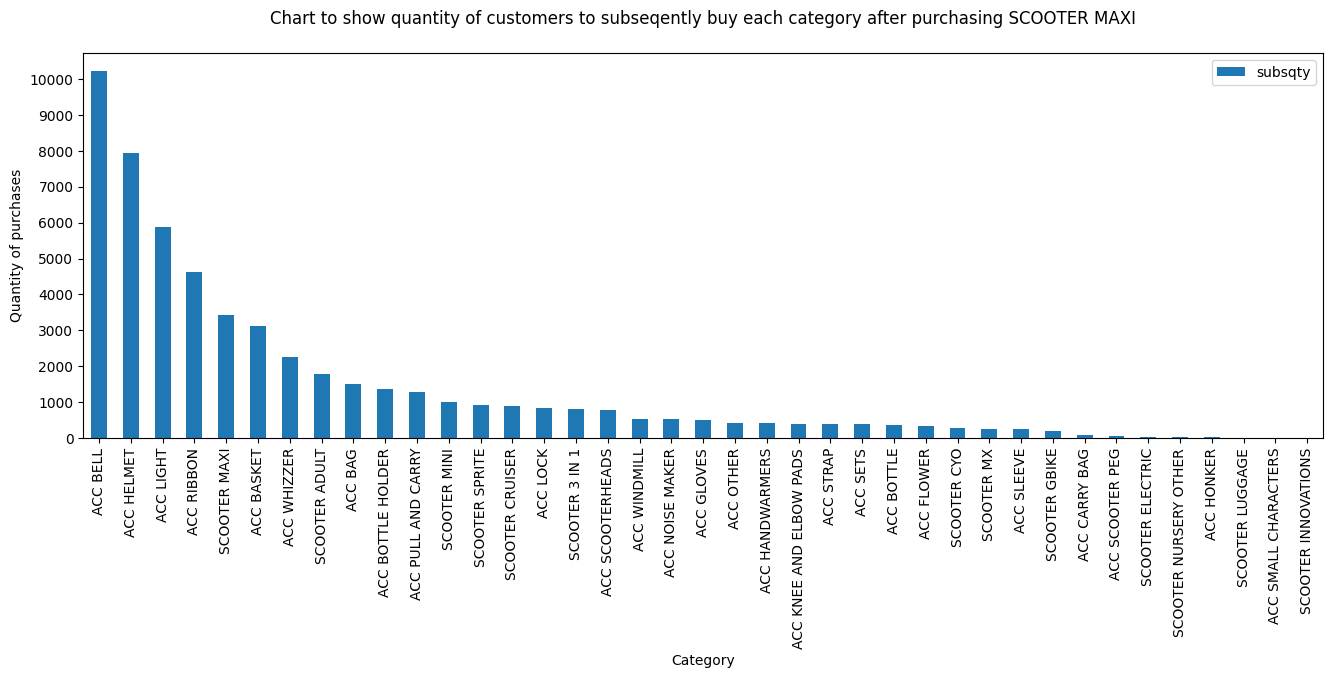

In [7]:
#names[0] is the first item in the list which is SCOOTER MINI
bestsellbar('SCOOTER MAXI', d1)

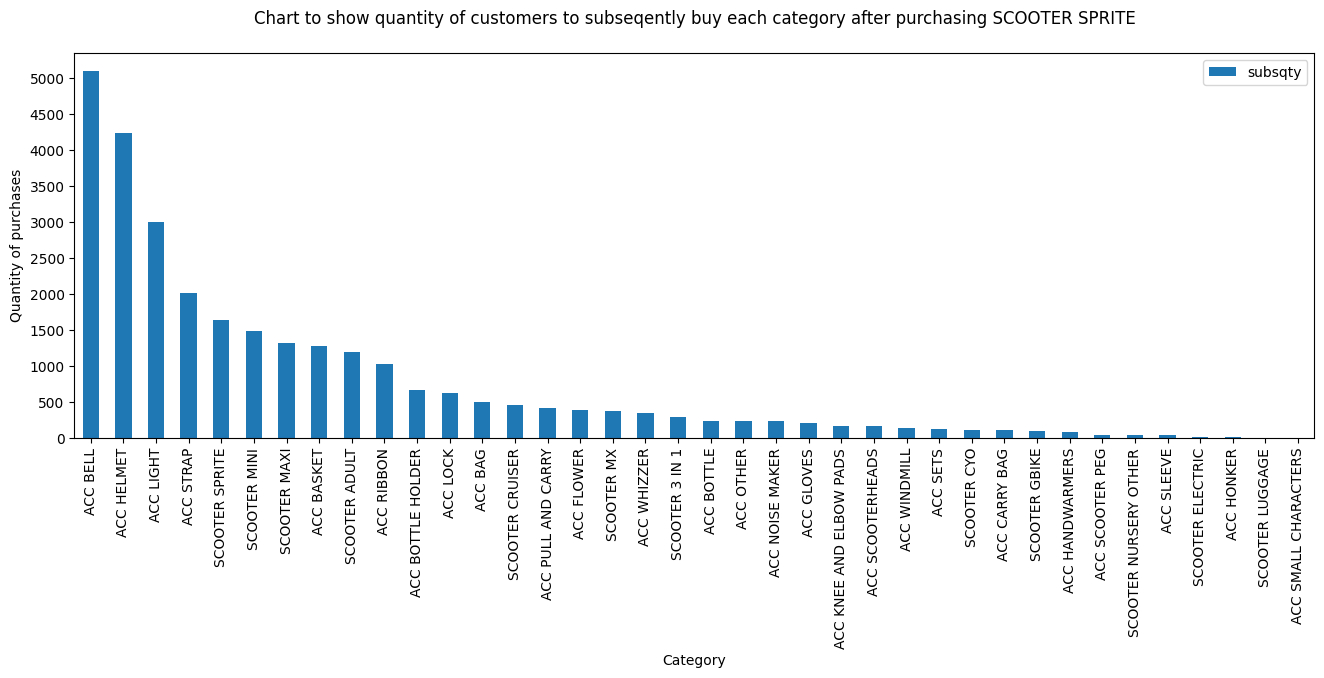

In [8]:
# names[1] contains the category SCOOTER MAXI
bestsellbar(names[2],d1)

I've only plotted the top 2 to minimize clutter. Looking at these barcharts, it is clear to see that the most polular subsequent purchases are the bells, helmets,lights and ribons. The most popular accessory to purchase also depends on the type of scooter bought first which is interesting. I have had a look at the other top categories and they show the same pattern. This would make sense logically I think that the first purchase would be a scooter and the second would be an accessory. I will look into the timeframe of these returns later.<br>

The function below shows the graphs above but tabularised in case the values want to be extracted. As an example, SCOOTER MAXI has been used to show the top 10 most popular subsequent categories.

In [9]:
def topsubs(name):
    d_product = d1.loc[d1['first'].str.contains(name)]
    d_product = d_product.groupby(['subs']).sum(['subsqty'])
    d_product = d_product.drop(columns = "subsnet")
    d_product = d_product.sort_values(['subsqty'],ascending=False)
    print('Subsequent to %s' % name)
    print(' ')
    print(d_product.head(10))
    print('-------------------')

    
# calling the top categories bought after the SCOOTER MAXI
topsubs(names[0])

Subsequent to SCOOTER MINI
 
                    subsqty
subs                       
ACC HELMET            19887
ACC BELL              13882
SCOOTER MAXI           6585
ACC RIBBON             6151
ACC PULL AND CARRY     5553
ACC LIGHT              4302
ACC BASKET             3384
SCOOTER MINI           2882
ACC WHIZZER            2178
ACC BAG                2101
-------------------


#### Percentages

The function below will tell you the percentage of customers that returned to purchase a category. ACC HELMET has been used for an example.

In [10]:
def percreturn(category):
    sumcat = d1.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet')
    sumcat = np.sum(sumcat.loc[sumcat.index.str.contains(category)])
    sumall = np.sum(d1.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet'))
    print("%0.1f%% of returning customers bought %s" % (sumcat['subsqty']/sumall['subsqty']*100,category))
    
percreturn('ACC HELMET')

20.0% of returning customers bought ACC HELMET


This is to show how many customers bought a Helmet (20%) subsequently. You can put any category in above and it will show you the percentage of subsequent purchases for it.
<br><br>


The next function will plot the subseqnent purchases for all top 5 first buys as this should give us more insight into the relationship between the first purchase

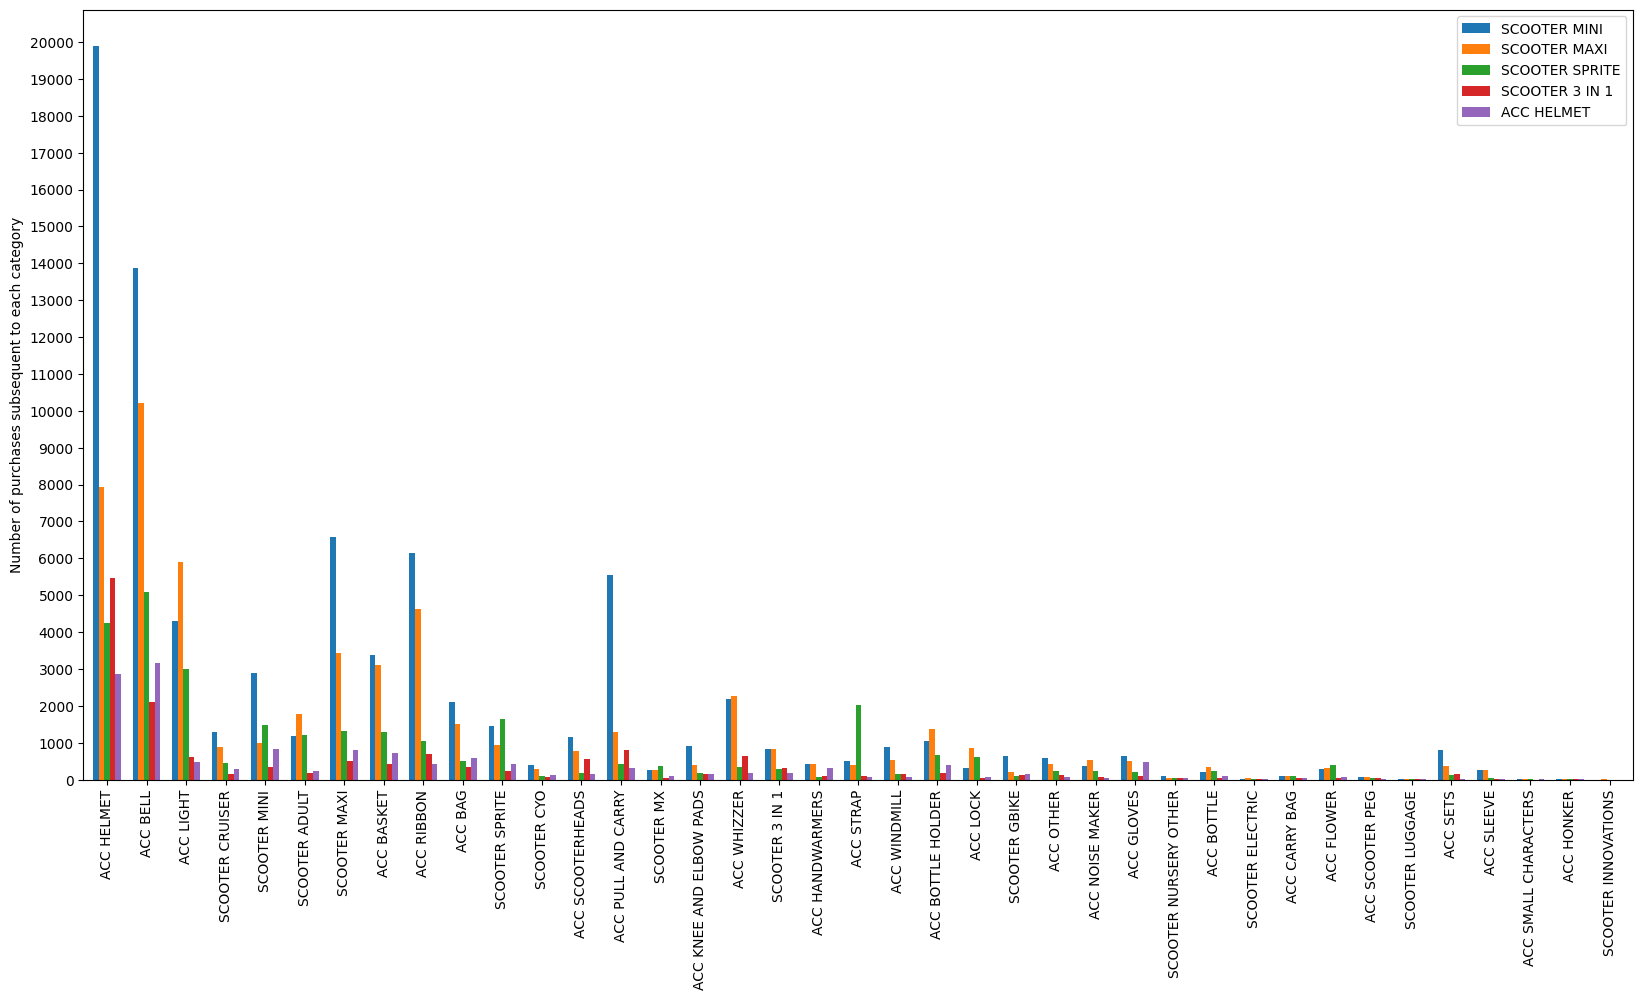

In [11]:
#barchart function, just enter any category from scooter or accessory
def bestsellbarmult(names, dx):
    d_product = []
    index = dx.loc[dx['first'].str.contains('|'.join(names))]
    index = index['subs'].value_counts().index
    df = pd.DataFrame(index = index)
    
    for i in range(len(names)):
        d_product = dx.loc[dx['first'].str.contains(names[i])]
        d_product = d_product.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False)
        d_product = d_product.drop(columns = "subsnet")
        #d_product.sort_values(['subsqty'],ascending=False) 
        df[names[i]] = d_product
    ax = df.plot.bar(rot=90,figsize = (20,10), width=0.7)
    plt.locator_params(axis='y',nbins=40)
    ax.set_ylabel("Number of purchases subsequent to each category")

bestsellbarmult(names,d1)

So this shows that by far the most likely buyers of a helmet the next time round are those who bought a SCOOTER MIMI followed by a SCOOTER MAXI. This trend is shown for a BELL as well and reversed for a LIGHT. However it just confirms that an accessory is usually the subsequent purhcase, especaily after buying a SCOOTER. Makes sense.

To calculate the probability of buying a category after another, you would also require the data for customers that did not return to purchase again.


In [12]:
def bestselloverall(names, barsize=(12,3)):
    d_product = d1.loc[d1['first'].str.contains('|'.join(names))]
    d_product = d_product.groupby(['subs']).sum(['subsqty'])
    d_product = d_product.drop(columns = "subsnet")
    d_product.sort_values(['subsqty'],ascending=False).plot(kind='bar', figsize=barsize)
    plt.ylabel("Percentage of customers [%]")
    plt.xlabel("Category")
    plt.title('Bar chart to show what customers are most likely to purchase subsequently to the %s\n' % names)
    plt.locator_params(axis='y', nbins=10)

In [13]:
#bestselloverall(names)

### Looking at Accessories alone
Below are the best selling accessories. The function will show the most popular subsequent accessory purchases after buying a certain accessory. As the bestsellbar() function is dynamic enough to change the dataframe, I have used the same function but used the subset that only includes accessories for first and subsequent purchases.

In [14]:
acc_only['first'].value_counts().head(5)

ACC HELMET            185
ACC WHIZZER           152
ACC PULL AND CARRY    141
ACC RIBBON            139
ACC BELL              120
Name: first, dtype: int64

Text(0.5, 1.0, 'Subsequent purchases within the accessories after buying a Helmet')

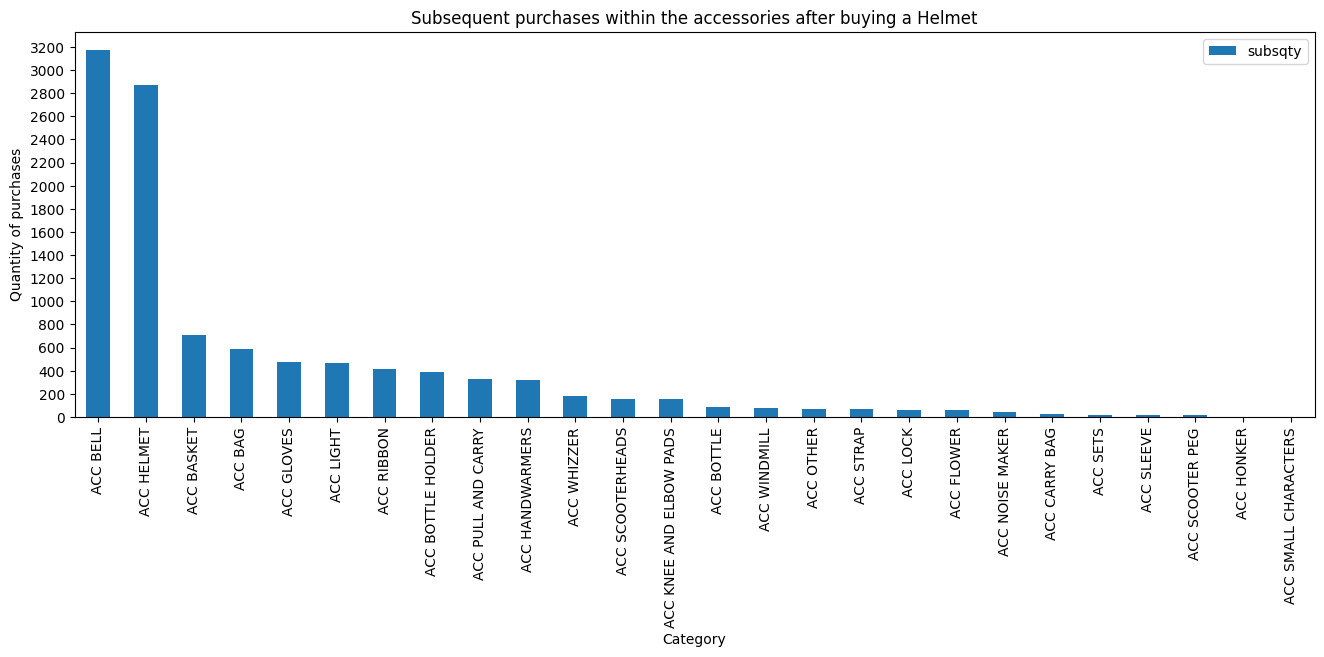

In [15]:
bestsellbar('ACC HELMET',acc_only)
plt.title("Subsequent purchases within the accessories after buying a Helmet")

***
### REPURCHASE PERIODS
Looking into repurchasing periods I have decided to show it using a piechart below. So, the way I have done it is to look into a certain first category and subsequent and seeing what percentage of those customers bought within each period segment. The following uses the example of buying a light the first time round and then returning the buy a light.

In [16]:
def repurchpie(name1,name2): 
    x = 1
    bool_f = d1['first'].str.contains(name1) 
    bool_s = d1['subs'].str.contains(name2)
    dx = d1.loc[bool_f & bool_s]
    explode = np.zeros(len(dx))
    explode = explode*x
    plt.pie(dx['subsqty'], startangle=90,explode = explode)
    plt.ylabel("")
    tot = np.sum(dx['subsqty'])
    perc = dx['subsqty']/tot*100
    plt.title("Repurchase period for a %s after buying a %s" % (name2,name1))
    labels = ['%s =  %1.1f%%' % (l, s) for l, s in zip(dx['period'], perc)]
    plt.legend(labels=labels,bbox_to_anchor=(1,1))
    plt.tight_layout()

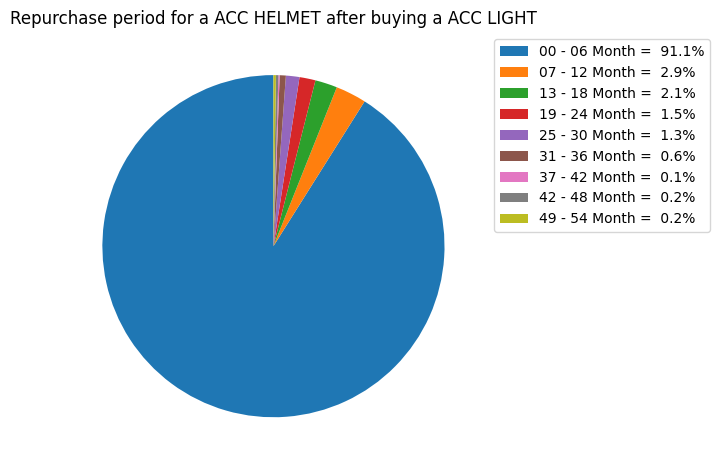

In [17]:
repurchpie('ACC LIGHT','ACC HELMET')

A more interesting combination would be the most popular first purchase followed by the most popular susequent purchase for that category. That would be a SCOOTER MINI followed by a ACC HELMET. This is shown below.

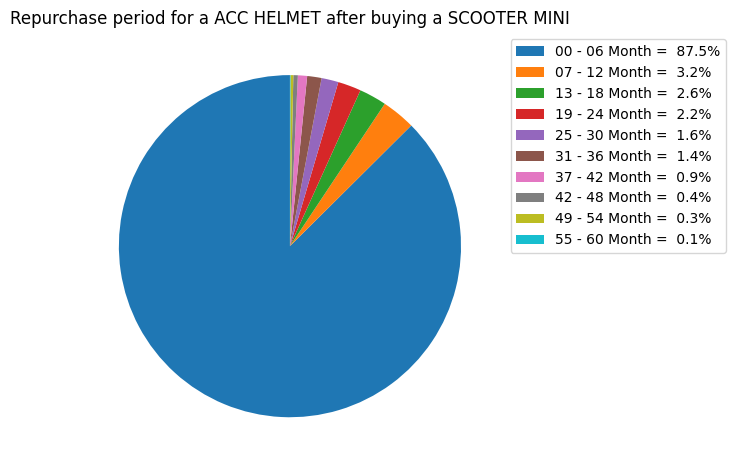

In [18]:
repurchpie('SCOOTER MINI','ACC HELMET')

This shows that 87.5% of customers that buy a helmet after a scooter mini buy within the first 6 months. The likely hood of them buying a helmet after the first six months drops dramatically.
<br>
To show this as a continuous graph, below shows just how dramatically the likelihood of purchasing falls to 0.

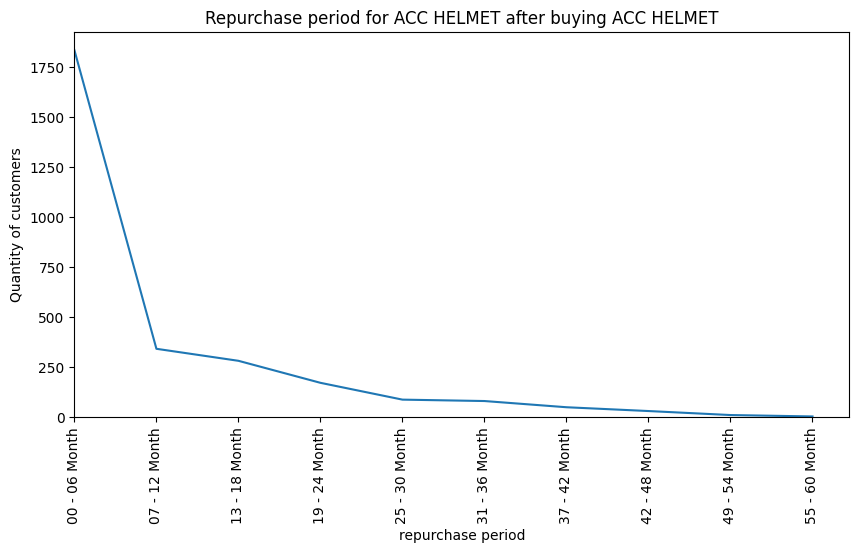

In [19]:
def purchovertime(name1,name2):  
    bool_f = d1['first'].str.contains(name1) 
    bool_s = d1['subs'].str.contains(name2)
    dx = d1.loc[bool_f & bool_s]
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(dx['period'],dx['subsqty'])
    plt.tick_params(axis='x',rotation=90)
    plt.ylabel('Quantity of customers')
    plt.xlabel("repurchase period")
    plt.title("Repurchase period for %s after buying %s" % (name2,name1))
    plt.xlim(0)
    plt.ylim(0)
    #return dx
    
purchovertime('ACC HELMET','ACC HELMET')

Below shows the repurchase period trend for buying a scooter maxi after first buying a light. There is less of a continuous trend for this.

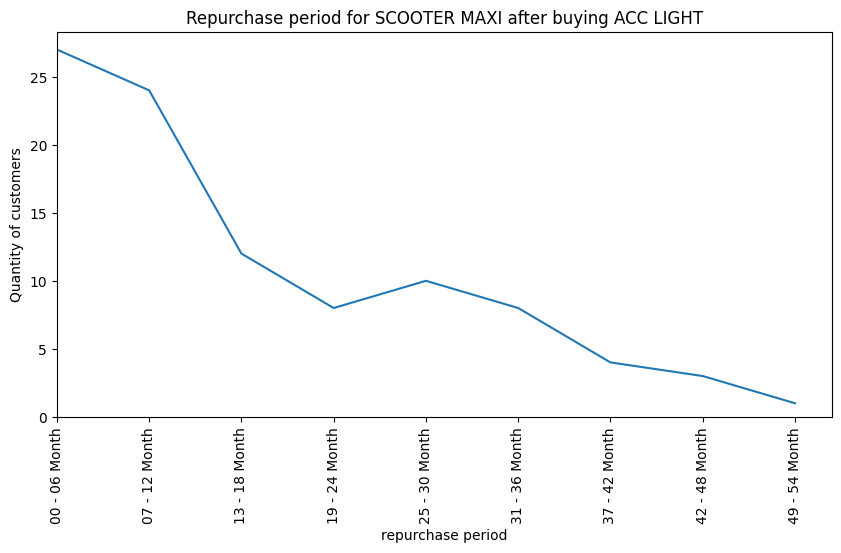

In [20]:
purchovertime('ACC LIGHT','SCOOTER MAXI')

***
#### Repurchasing within the first 6 months

Below is a chart which shows the quanity of subsequent purchases per category within the first 6 months. It clearly shows that the subsequent purchase is very likely to be an accessory.

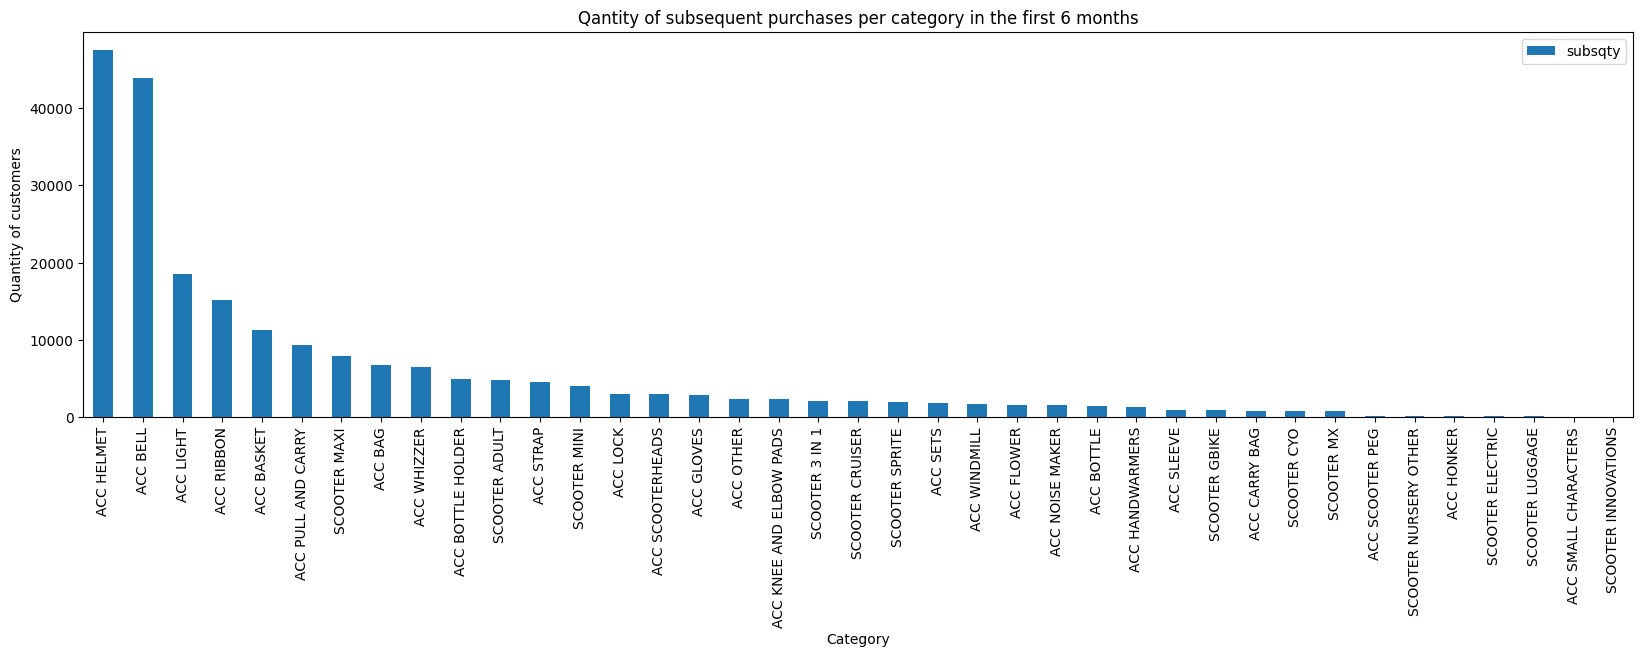

In [21]:
zerotosix.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet').head(100).plot(kind='bar', figsize=(20,5))
plt.title('Qantity of subsequent purchases per category in the first 6 months')
plt.ylabel('Quantity of customers')
plt.xlabel('Category')
plt.tick_params(axis='x',rotation=90)

In [22]:
topzeroto6 = zerotosix.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet').head(5)
sumtop = np.sum(topzeroto6)
sumall = np.sum(zerotosix.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet'))
print("%0.1f%% of customers that returned within the first 6 months purchased the top 5 accessories" % (sumtop/sumall*100))

62.3% of customers that returned within the first 6 months purchased the top 5 accessories


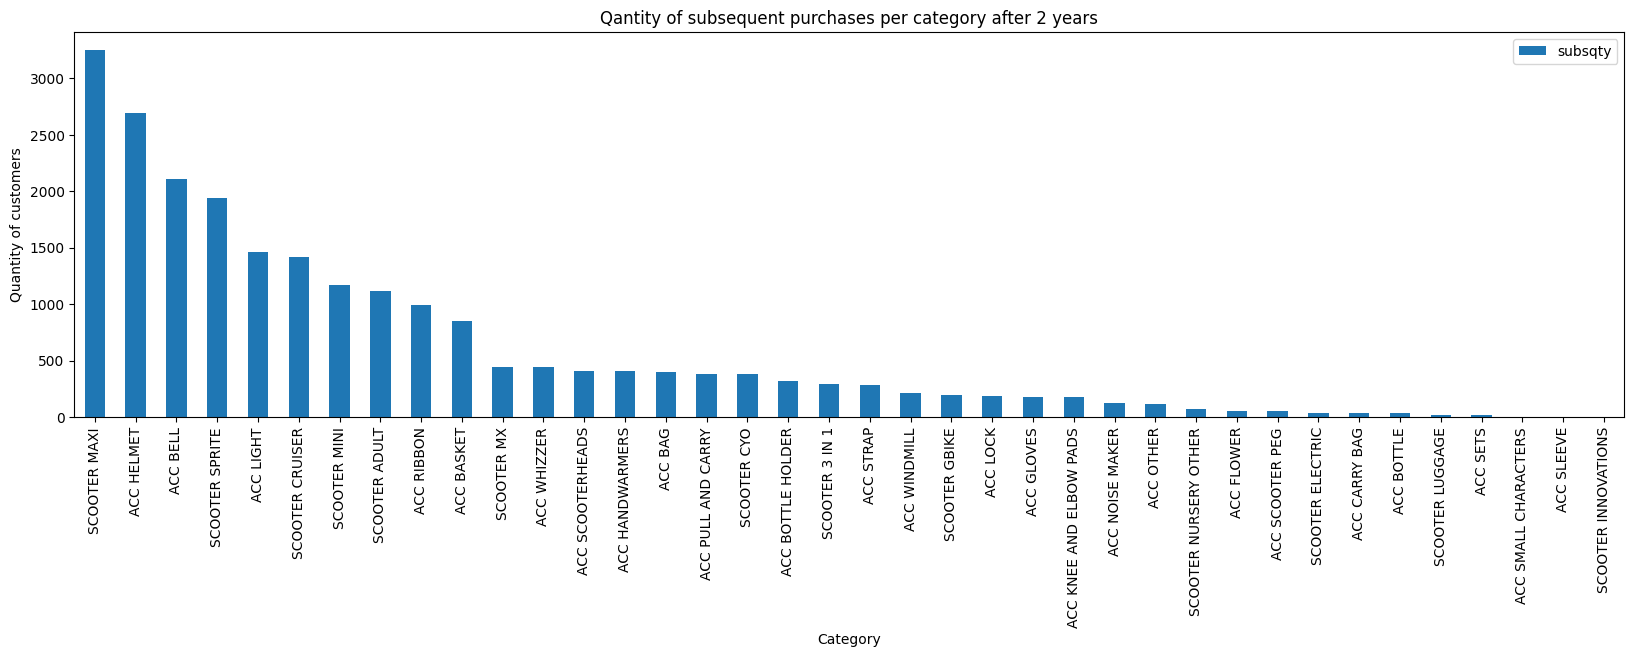

In [23]:
not_first_2years.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet').head(100).plot(kind='bar', figsize=(20,5))
plt.title('Qantity of subsequent purchases per category after 2 years')
plt.ylabel('Quantity of customers')
plt.xlabel('Category')
plt.tick_params(axis='x',rotation=90)

In [24]:
topzeroto6 = not_first_2years.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet').head(5)
sumtop = np.sum(topzeroto6)
sumall = np.sum(not_first_2years.groupby(['subs']).sum(['subsqty']).sort_values(['subsqty'],ascending=False).drop(columns='subsnet'))
print("%0.1f%% of customers that returned within the first 6 months purchased the top 5 accessories" % (sumtop/sumall*100))

51.5% of customers that returned within the first 6 months purchased the top 5 accessories


For customers that return after 2 years, the percentage of those who buy the top 5 items falls to 51.5%. This means that the longer it takes for a customer to return, the less easy it is to predict what they will buy however there is still a trend.

***
### Standard Deviation and Normal Distribution

The scipy.stats function uses the following equation for the Normal Distribution:
$$f(x)=\frac{1}{\sigma\sqrt{2 \pi}} exp\left[-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right]$$

This normal distribution will require the mean value which the curve centres on and the standard deviation with equation:
$$\sigma=\sqrt{\frac{\Sigma(x_i-\mu)^2}{N}}$$

where:

$N$=population size

$x_i$=each value

$\mu$=population mean

By showing the value of the standard deviation before the normal distribution, we can compare the values and see the relationship of dispersion between the categories.

As the subsequent value before returns column is a count, an additional column us required to divide the subsnet by the subsqty to find the average spend per customer. This column will be named as 'spent'

In [25]:
def normdist(df):
    spent = []
    df['values'] = df['subsnet'] / df['subsqty']
    for i in range(len(df)):
        for j in range(df['subsqty'].iloc[i]):
            spent.append(df['values'].iloc[i])

    spent = sorted(spent)
    vals_mean = np.mean(spent)
    vals_stddev = stats.tstd(spent)
    nd = norm.pdf(spent, vals_mean, vals_stddev)

    fig, ax = plt.subplots(figsize = (10,6))
    ax.plot(spent, nd)
    ax.set_xlabel('amount spent [£]')
    print("A standard deviation of £%.0f" % (vals_stddev))
    print("A mean of £%.0f" % (vals_mean))

/var/folders/vh/xnr2f9hn3b57nzdtnpbrknk80000gn/T/ipykernel_26756/854495850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['values'] = df['subsnet'] / df['subsqty']


A standard deviation of £36
A mean of £28


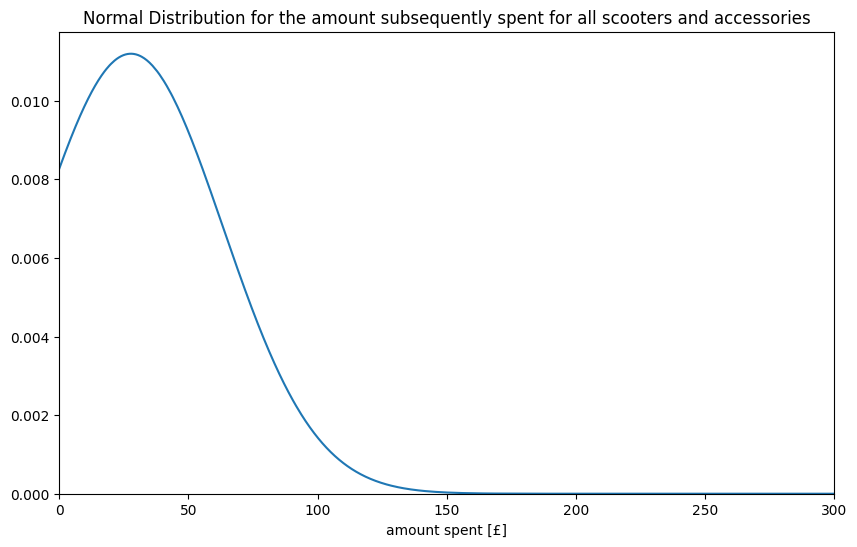

In [32]:
normdist(d1)
plt.title('Normal Distribution for the amount subsequently spent for all scooters and accessories')
plt.xlim([0,300])
plt.ylim(0)
#plt.savefig('Normal_Distribution_scooters_and_accessories_subsequent_spend.pdf')

/var/folders/vh/xnr2f9hn3b57nzdtnpbrknk80000gn/T/ipykernel_26756/854495850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['values'] = df['subsnet'] / df['subsqty']


A standard deviation of £31
A mean of £95


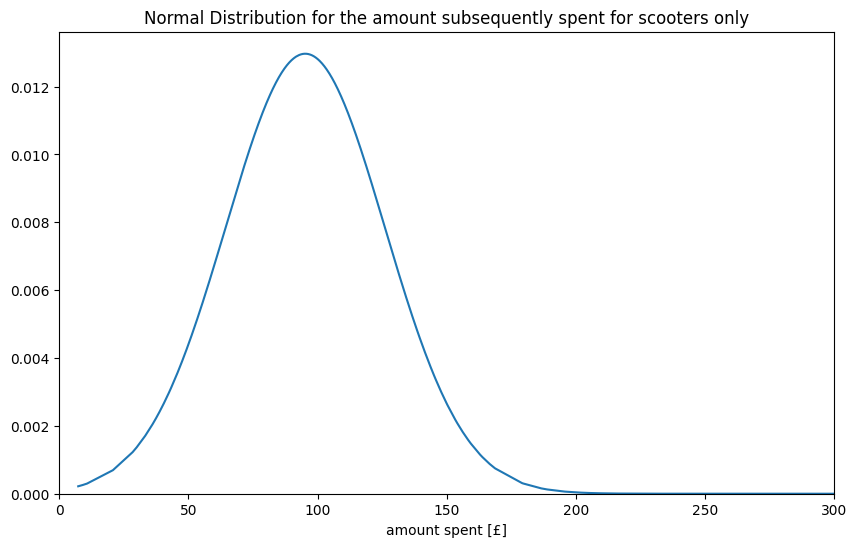

In [33]:
normdist(scoot_subs)
plt.title('Normal Distribution for the amount subsequently spent for scooters only')
plt.xlim([0,300])
plt.ylim(0)
#plt.savefig('Normal_Distribution_scooters_subsequent_spend.pdf')

/var/folders/vh/xnr2f9hn3b57nzdtnpbrknk80000gn/T/ipykernel_26756/854495850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['values'] = df['subsnet'] / df['subsqty']


A standard deviation of £9
A mean of £12


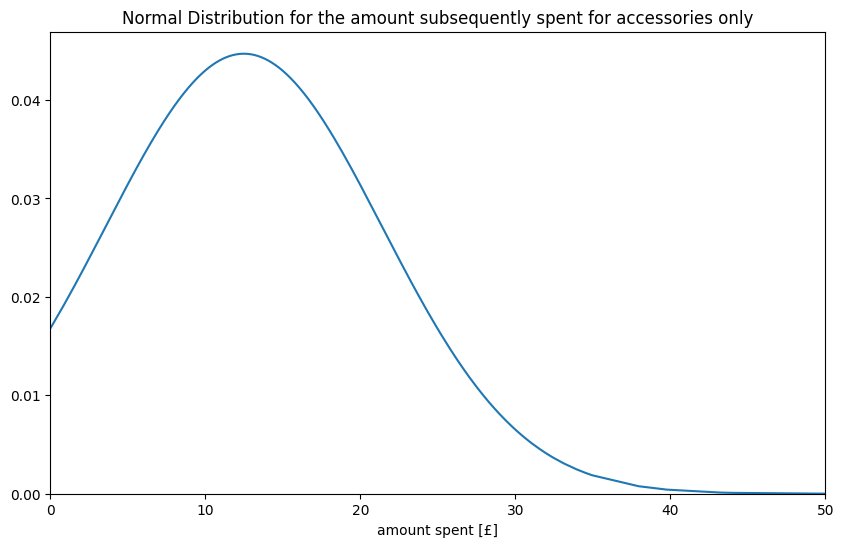

In [34]:
normdist(acc_subs)
plt.title('Normal Distribution for the amount subsequently spent for accessories only')
plt.xlim([0,50])
plt.ylim(0)
#plt.savefig('Normal_Distribution_accessories_subsequent_spend.pdf')

As expected, looking at the distribution between buying a scooter and an accessory, the mean for buying a scooter is much higher but easier to predict the amount spent as it has a relatively smaller standard deviation than the accessories. With accessories, 34% of customers can buy from £3 up to £21 which within the distribution is quite a big spread.

### Looking into probability
Conditional probability is the probability of picking an item given that a certain item has been picked which is what is wanted here.

$$P(B|A) = \frac{P(A \cap B)}{P(A)}$$



In [29]:
groupedd1 = d1.groupby(['subs']).sum(['subsqty']).sort_values(['subsnet'],ascending = True)
total = groupedd1['subsqty'].sum()

scoot_subs_qty = groupedd1.loc[groupedd1.index.str.contains('SCOOTER ')]
sum_scoot_subs_qty = scoot_subs_qty['subsqty'].sum()

acc_subs_qty = groupedd1.loc[groupedd1.index.str.contains('ACC ')]
sum_acc_subs_qty = acc_subs_qty['subsqty'].sum()

In [30]:
print("%.1f%% of customers bought an accessory given that they bought a scooter or accessory first" % (sum_acc_subs_qty/total*100))
print("%.1f%% of customers bought an scooter given that they bought a scooter or accessory first" % (sum_scoot_subs_qty/total*100))

81.7% of customers bought an accessory given that they bought a scooter or accessory first
18.4% of customers bought an scooter given that they bought a scooter or accessory first


Above I have shown the percentage of customers that returned to buy a scooter or accessory given that they will buy one or the other.

This can then be narrowed down to certain categories. below I am showing the percentage / probability of buying a Light given that a scooter or accessory was bought the first time round.

In [31]:
def prob_of_purchase(first,second):
    buying_first = d1.loc[d1['first'].str.contains(first)]
    grouping = buying_first.groupby(['subs']).sum(['subsqty'])
    total = grouping['subsqty'].sum()
    subsamount = grouping.loc[grouping.index.str.contains(second)]
    #print(subsamount['subsqty'])
    #print(total)
    print('the probability of buying a %s after buying %s is %.2f' % (second, first, subsamount['subsqty'] / total))
    #print(grouping)
    

prob_of_purchase('SCOOTER MINI','ACC HELMET')

the probability of buying a ACC HELMET after buying SCOOTER MINI is 0.24


Here I have taken the quantity of all customers to buy the scooters and accessories. The data was narrowed down to the amount that just bought a certain first category, in this case a scooter mini. The number of customers that bought a certain subsequent item, in this case the helmet, was then calculated which was divided by the total amount that bought a scooter mini the first time.